## Training

Using this notebook, we train on a subset of classes (phenotypes). For example, we leave out the mitochondrial phenotype.

**Naming the experiment**

In [1]:
run_desc = 'chong_no_batch_only_EndoErMito'

### Getting the data

Downloading the data if not present

In [2]:
#Taken from https://github.com/okraus/DeepLoc/blob/master/download_datasets.sh
import os
if not (os.path.exists('datasets/Chong_train_set.hdf5')):
    !curl http://spidey.ccbr.utoronto.ca/~okraus/DeepLoc_full_datasets.zip --output DeepLoc_full_datasets.zip
    !unzip DeepLoc_full_datasets.zip
    !rm DeepLoc_full_datasets.zip
!ls -lh datasets

total 3.2G
-rw-r--r-- 1 root root 153M Jan  7  2017 Chong_test_set.hdf5
-rw-r--r-- 1 root root 738M Jan  7  2017 Chong_train_set.hdf5
-rw-r--r-- 1 root root 152M Jan  7  2017 Chong_valid_set.hdf5
-rw-r--r-- 1 root root  740 Jan  8  2017 README.TXT
-rw-r--r-- 1 root root  46M Jan  8  2017 Schuldiner_test_set.hdf5
-rw-r--r-- 1 root root 405M Jan  8  2017 Schuldiner_train_set.hdf5
-rw-r--r-- 1 root root 172M Jan  8  2017 wt2017_test_set.hdf5
-rw-r--r-- 1 root root 1.5G Jan  8  2017 wt2017_train_set.hdf5


In [3]:
!nvidia-smi

Mon Apr 16 07:45:09 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.30                 Driver Version: 390.30                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:89:00.0 Off |                    0 |
| N/A   35C    P0    46W / 250W |      0MiB / 22919MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
import tensorflow as tf
import keras


from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Flatten, Activation
from keras.layers import Lambda, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
from keras import initializers
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input

from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.contrib.keras.python.keras.layers.merge import Concatenate
# from tensorflow.contrib.keras.python.keras.layers import Lambda, RepeatVector

import h5py
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
tf.__version__,keras.__version__, np.__version__, h5py.__version__

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


('1.6.0', '2.1.5', '1.14.1', '2.7.1')

## Data Loading

In [5]:
fn1 = 'datasets/Chong_train_set.hdf5'
d1 = h5py.File(fn1)
print(list(d1.keys()))
l = [d for d in zip(np.argmax(d1['Index1'],axis=1), d1['label_names'])]
from collections import Counter
Counter(l)

['Index1', 'Info1', 'data1', 'label_names']


Counter({(0, b'ACTIN'): 738,
         (1, b'BUDNECK'): 535,
         (2, b'BUDTIP'): 336,
         (3, b'CELLPERIPHERY'): 423,
         (4, b'CYTOPLASM'): 1500,
         (5, b'ENDOSOME'): 1500,
         (6, b'ER'): 1500,
         (7, b'GOLGI'): 1500,
         (8, b'MITOCHONDRIA'): 1500,
         (9, b'NUCLEARPERIPHERY'): 1500,
         (10, b'NUCLEI'): 1500,
         (11, b'NUCLEOLUS'): 1500,
         (12, b'PEROXISOME'): 988,
         (13, b'SPINDLE'): 185,
         (14, b'SPINDLEPOLE'): 1500,
         (15, b'VACUOLARMEMBRANE'): 1500,
         (16, b'VACUOLE'): 1500,
         (17, b'DEAD'): 749,
         (18, b'GHOST'): 1428})

In [6]:
def flatBatch2Tensor(batchData,imSize,channels):
    splitByChannel = [batchData[:,(chan*imSize**2):((chan+1)*imSize**2)].reshape((-1,imSize,imSize,1)) \
                      for chan in range(channels)]
    tensorBatchData = np.concatenate(splitByChannel,3)
    return tensorBatchData

def load_kraus():
       
    #fn1 = 'datasets/wt2017_train_set.hdf5'
    #fn2 = 'datasets/wt2017_test_set.hdf5'
    
    fn1 = 'datasets/Chong_train_set.hdf5'
    fn2 = 'datasets/Chong_test_set.hdf5'
    fn3 = 'datasets/Chong_valid_set.hdf5'
    d1 = h5py.File(fn1)
    d2 = h5py.File(fn2)
    d3 = h5py.File(fn3)
    
    X_train = flatBatch2Tensor(d1['data1'][:], 64, 2)
    X_test = flatBatch2Tensor(d2['data1'][:], 64, 2)
    X_valid = flatBatch2Tensor(d3['data1'][:], 64, 2)
    y_train = d1['Index1'][:]
    y_test = d2['Index1'][:]
    y_valid = d3['Index1'][:]
    
    # We bring the data into the range [0,1] and clamp it due to heavy outliers
    X_train = np.clip(X_train,0,100)/100
    X_test = np.clip(X_test,0,100)/100
    X_valid = np.clip(X_valid,0,100)/100
    
    # For sparse labels
    #y_train = np.ndarray.astype(np.argmax(d1['Index1'],axis=1),'int32')
    #y_test = np.ndarray.astype(np.argmax(d2['Index1'],axis=1),'int32')
        
    print("X_train type {} dtype {} shape {}".format(type(X_train), X_train.dtype,np.shape(X_train)))
    print("X_train min {}, max {} mean {}".format(np.min(X_train), np.max(X_train), np.mean(X_train)))
    print("Y_train shape {} Y_test shape{} Y_validation shape{} ".format(np.shape(y_train), np.shape(y_test), np.shape(y_valid)))
    return X_train, y_train, X_test, y_test, X_valid, y_valid

In [7]:
import h5py
import numpy as np
X_train, Y_train, X_test, Y_test, X_valid, Y_valid = load_kraus()

X_train type <class 'numpy.ndarray'> dtype float32 shape (21882, 64, 64, 2)
X_train min 0.0, max 1.0 mean 0.17277522385120392
Y_train shape (21882, 19) Y_test shape(4516, 19) Y_validation shape(4491, 19) 


In [8]:
np.max(np.argmax(Y_train, axis=1)) + 1, Y_valid.shape #19 number of classes - 1

(19, (4491, 19))

### Removing cells in the training and validation set

We remove the e.g. mitochondrial cells from the training and validation set.

In [9]:
y_train = np.argmax(Y_train,axis=1)
y_valid = np.argmax(Y_valid,axis=1)
y_test = np.argmax(Y_test,axis=1)

y_max = np.max(y_train) #0,...
num_class_org = y_max + 1
print('Number of classes (original)', num_class_org, '   from', 0, 'to', y_max)

Number of classes (original) 19    from 0 to 18


We build a list of classes which shall be used in the training.

In [12]:
## For myto
if True:
    myto_idx = 8
    keep_idx = list(np.linspace(start=0,stop=y_max,num=y_max+1, dtype='int32'))
    keep_idx.remove(myto_idx)
    keep_idx.remove(4) #4 For Cyo

In [13]:
## For EndoErMito
#keep_idx = list((5,6,8))

In [12]:
keep_idx = list(range(0, 10))

In [13]:
num_classes = len(keep_idx)
print("Number of classes (after cutting)" , num_classes, "to keep from org", keep_idx)

all_to_limited = dict()
limited_to_all = dict()
c = 0
for i in range(num_class_org):
    all_to_limited[i] = c
    limited_to_all[c] = i
    if (keep_idx.count(i) > 0):
        c += 1
#all_to_limited
#limited_to_all

Number of classes (after cutting) 10 to keep from org [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [14]:
keep_training = [keep_idx.count(y) > 0 for y in y_train]
X_train_keep = X_train[keep_training]
y_train_keep = [all_to_limited[y] for y in y_train if keep_idx.count(y) > 0] 

keep_valid = [keep_idx.count(y) > 0 for y in y_valid]
X_valid_keep = X_valid[keep_valid]
y_valid_keep = [all_to_limited[y] for y in y_valid if keep_idx.count(y) > 0] 

X_train_keep.shape, X_valid_keep.shape, len(np.unique(y_train_keep)), len(np.unique(y_valid_keep))  

((11032, 64, 64, 2), (2392, 64, 64, 2), 10, 10)

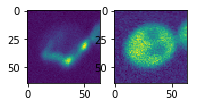

In [16]:
plt.subplot(1,4,1)
plt.imshow(X_train_keep[len(X_train_keep)-1,:,:,0])
plt.subplot(1,4,2)
plt.imshow(X_train_keep[len(X_train_keep)-1,:,:,1])

## Building of Model and Training

In [17]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    #zoom_range=[0.1,0.1]
)

In [18]:
# Helper functions
def one_hot(Y, num_cl):
    d = np.zeros((len(Y),num_cl), dtype='int8')
    for row,col in enumerate(Y):
        d[row, col] = 1
    return d
one_hot(np.array((1,0,1,1,2)), 3).shape

(5, 3)

In [19]:
batch_size = 128
train_generator = datagen.flow(
        x = X_train_keep,
        y = one_hot(y_train_keep, num_classes),
        batch_size = batch_size,
        shuffle = True)

/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:935: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (11032, 64, 64, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [20]:
tf.reset_default_graph()
model = Sequential()

model.add(Convolution2D(32, (3,3),kernel_initializer='he_normal',padding='same',input_shape=(64,64,2)))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.3))
model.add(Convolution2D(32, (3,3),kernel_initializer='he_normal',padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Convolution2D(64, (3,3),kernel_initializer='he_normal',padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Convolution2D(64, (3,3),kernel_initializer='he_normal',padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())#macht einen vektor aus dem output
model.add(Dropout(0.3))            
model.add(Dense(200,kernel_initializer='he_normal'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.3))
model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
print(model.summary())
model.input_shape, model.output_shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        608       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 32)        0         
__________

((None, 64, 64, 2), (None, 10))

In [22]:
import glob
import os
def create_result_subdir(result_dir, run_desc):
    ordinal = 0
    for fname in glob.glob(os.path.join(result_dir, '*')):
        try:
            fbase = os.path.basename(fname)
            ford = int(fbase[:fbase.find('-')])
            ordinal = max(ordinal, ford + 1)
        except ValueError:
            pass

    result_subdir = os.path.join(result_dir, '%03d-%s' % (ordinal, run_desc))
    if os.path.isdir(result_subdir):
        return create_result_subdir(result_dir, run_desc) # Retry.
    if not os.path.isdir(result_subdir):
        os.makedirs(result_subdir)
    return result_subdir, ordinal

In [23]:
resdir, ordinal = create_result_subdir('results_bayes', run_desc)

In [24]:
resdir

'results_bayes/015-chong_no_batch_only_EndoErMito'

In [25]:
tb_cb = keras.callbacks.TensorBoard(log_dir=resdir, histogram_freq=0, write_graph=True)

In [26]:
checkpointer = keras.callbacks.ModelCheckpoint( 
    filepath =  resdir+"/weights_Chong_data_epoch_{epoch:03d}-{val_loss:.2f}.hdf5",
    verbose = 1, 
    save_best_only = False,
    period = 25 )

In [27]:
one_hot(y_valid_keep, num_classes).shape, num_classes, num_class_org,one_hot(y_train_keep, num_classes).shape

((2392, 10), 10, 19, (11032, 10))

In [28]:
history = model.fit_generator(
                    train_generator,
                    steps_per_epoch = X_train_keep.shape[0]/batch_size,
                    epochs = 500,                    
                    validation_data = (X_valid_keep, one_hot(y_valid_keep, num_classes)),
                    verbose = 2,
                    callbacks=[checkpointer, tb_cb]
)
model.save(resdir+"/final.keras.model")

Epoch 1/500
 - 11s - loss: 2.0859 - acc: 0.2400 - val_loss: 1.7894 - val_acc: 0.3181
Epoch 2/500
 - 9s - loss: 1.6730 - acc: 0.3744 - val_loss: 1.6588 - val_acc: 0.4214
Epoch 3/500
 - 10s - loss: 1.5169 - acc: 0.4408 - val_loss: 1.4318 - val_acc: 0.5184
Epoch 4/500
 - 9s - loss: 1.3043 - acc: 0.5245 - val_loss: 1.2369 - val_acc: 0.5727
Epoch 5/500
 - 10s - loss: 1.1784 - acc: 0.5729 - val_loss: 1.0164 - val_acc: 0.6543
Epoch 6/500
 - 9s - loss: 1.0389 - acc: 0.6242 - val_loss: 0.8699 - val_acc: 0.6961
Epoch 7/500
 - 9s - loss: 0.9759 - acc: 0.6517 - val_loss: 0.8233 - val_acc: 0.7149
Epoch 8/500
 - 9s - loss: 0.9299 - acc: 0.6634 - val_loss: 0.7652 - val_acc: 0.7287
Epoch 9/500
 - 9s - loss: 0.8648 - acc: 0.6820 - val_loss: 0.6737 - val_acc: 0.7701
Epoch 10/500
 - 10s - loss: 0.8325 - acc: 0.6986 - val_loss: 0.6727 - val_acc: 0.7625
Epoch 11/500
 - 9s - loss: 0.7988 - acc: 0.7109 - val_loss: 0.6247 - val_acc: 0.7977
Epoch 12/500
 - 9s - loss: 0.7643 - acc: 0.7213 - val_loss: 0.6119 - v

Epoch 102/500
 - 9s - loss: 0.2509 - acc: 0.9118 - val_loss: 0.2264 - val_acc: 0.9243
Epoch 103/500
 - 10s - loss: 0.2301 - acc: 0.9180 - val_loss: 0.2713 - val_acc: 0.9151
Epoch 104/500
 - 9s - loss: 0.2352 - acc: 0.9187 - val_loss: 0.2255 - val_acc: 0.9247
Epoch 105/500
 - 10s - loss: 0.2283 - acc: 0.9200 - val_loss: 0.2379 - val_acc: 0.9256
Epoch 106/500
 - 9s - loss: 0.2407 - acc: 0.9153 - val_loss: 0.2474 - val_acc: 0.9231
Epoch 107/500
 - 9s - loss: 0.2380 - acc: 0.9171 - val_loss: 0.2456 - val_acc: 0.9164
Epoch 108/500
 - 9s - loss: 0.2382 - acc: 0.9145 - val_loss: 0.2344 - val_acc: 0.9243
Epoch 109/500
 - 9s - loss: 0.2295 - acc: 0.9209 - val_loss: 0.2055 - val_acc: 0.9360
Epoch 110/500
 - 9s - loss: 0.2430 - acc: 0.9133 - val_loss: 0.2021 - val_acc: 0.9356
Epoch 111/500
 - 9s - loss: 0.2305 - acc: 0.9218 - val_loss: 0.2512 - val_acc: 0.9193
Epoch 112/500
 - 10s - loss: 0.2262 - acc: 0.9237 - val_loss: 0.3209 - val_acc: 0.9030
Epoch 113/500
 - 10s - loss: 0.2291 - acc: 0.9218 -

Epoch 193/500
 - 10s - loss: 0.1857 - acc: 0.9341 - val_loss: 0.2316 - val_acc: 0.9327
Epoch 194/500
 - 9s - loss: 0.1798 - acc: 0.9365 - val_loss: 0.2291 - val_acc: 0.9344
Epoch 195/500
 - 9s - loss: 0.1849 - acc: 0.9340 - val_loss: 0.2247 - val_acc: 0.9327
Epoch 196/500
 - 9s - loss: 0.1856 - acc: 0.9337 - val_loss: 0.2380 - val_acc: 0.9319
Epoch 197/500
 - 9s - loss: 0.1815 - acc: 0.9359 - val_loss: 0.2131 - val_acc: 0.9352
Epoch 198/500
 - 9s - loss: 0.1904 - acc: 0.9349 - val_loss: 0.2440 - val_acc: 0.9289
Epoch 199/500
 - 9s - loss: 0.1927 - acc: 0.9311 - val_loss: 0.2214 - val_acc: 0.9344
Epoch 200/500
 - 9s - loss: 0.1842 - acc: 0.9329 - val_loss: 0.1961 - val_acc: 0.9440

Epoch 00200: saving model to results_bayes/015-chong_no_batch_only_EndoErMito/weights_Chong_data_epoch_200-0.20.hdf5
Epoch 201/500
 - 9s - loss: 0.1780 - acc: 0.9367 - val_loss: 0.2296 - val_acc: 0.9344
Epoch 202/500
 - 9s - loss: 0.1859 - acc: 0.9354 - val_loss: 0.2413 - val_acc: 0.9310
Epoch 203/500
 - 9s -

Epoch 283/500
 - 9s - loss: 0.1645 - acc: 0.9437 - val_loss: 0.2127 - val_acc: 0.9373
Epoch 284/500
 - 9s - loss: 0.1618 - acc: 0.9436 - val_loss: 0.2048 - val_acc: 0.9385
Epoch 285/500
 - 9s - loss: 0.1631 - acc: 0.9417 - val_loss: 0.2151 - val_acc: 0.9365
Epoch 286/500
 - 9s - loss: 0.1561 - acc: 0.9441 - val_loss: 0.1938 - val_acc: 0.9411
Epoch 287/500
 - 10s - loss: 0.1436 - acc: 0.9495 - val_loss: 0.2472 - val_acc: 0.9289
Epoch 288/500
 - 9s - loss: 0.1601 - acc: 0.9451 - val_loss: 0.2333 - val_acc: 0.9323
Epoch 289/500
 - 9s - loss: 0.1506 - acc: 0.9474 - val_loss: 0.1975 - val_acc: 0.9423
Epoch 290/500
 - 9s - loss: 0.1532 - acc: 0.9456 - val_loss: 0.2898 - val_acc: 0.9214
Epoch 291/500
 - 9s - loss: 0.1540 - acc: 0.9459 - val_loss: 0.2083 - val_acc: 0.9394
Epoch 292/500
 - 9s - loss: 0.1504 - acc: 0.9467 - val_loss: 0.1852 - val_acc: 0.9465
Epoch 293/500
 - 9s - loss: 0.1705 - acc: 0.9417 - val_loss: 0.2120 - val_acc: 0.9348
Epoch 294/500
 - 9s - loss: 0.1708 - acc: 0.9436 - va

Epoch 374/500
 - 10s - loss: 0.1329 - acc: 0.9533 - val_loss: 0.2431 - val_acc: 0.9293
Epoch 375/500
 - 9s - loss: 0.1393 - acc: 0.9500 - val_loss: 0.2020 - val_acc: 0.9394

Epoch 00375: saving model to results_bayes/015-chong_no_batch_only_EndoErMito/weights_Chong_data_epoch_375-0.20.hdf5
Epoch 376/500
 - 10s - loss: 0.1339 - acc: 0.9538 - val_loss: 0.2408 - val_acc: 0.9256
Epoch 377/500
 - 9s - loss: 0.1370 - acc: 0.9518 - val_loss: 0.2069 - val_acc: 0.9406
Epoch 378/500
 - 9s - loss: 0.1347 - acc: 0.9529 - val_loss: 0.2151 - val_acc: 0.9440
Epoch 379/500
 - 9s - loss: 0.1392 - acc: 0.9497 - val_loss: 0.1903 - val_acc: 0.9452
Epoch 380/500
 - 9s - loss: 0.1396 - acc: 0.9495 - val_loss: 0.2087 - val_acc: 0.9381
Epoch 381/500
 - 10s - loss: 0.1270 - acc: 0.9547 - val_loss: 0.2231 - val_acc: 0.9335
Epoch 382/500
 - 10s - loss: 0.1462 - acc: 0.9482 - val_loss: 0.2310 - val_acc: 0.9310
Epoch 383/500
 - 9s - loss: 0.1288 - acc: 0.9554 - val_loss: 0.2336 - val_acc: 0.9335
Epoch 384/500
 - 9

Epoch 464/500
 - 9s - loss: 0.1267 - acc: 0.9562 - val_loss: 0.2389 - val_acc: 0.9352
Epoch 465/500
 - 9s - loss: 0.1241 - acc: 0.9580 - val_loss: 0.2397 - val_acc: 0.9323
Epoch 466/500
 - 9s - loss: 0.1191 - acc: 0.9592 - val_loss: 0.2653 - val_acc: 0.9293
Epoch 467/500
 - 9s - loss: 0.1277 - acc: 0.9561 - val_loss: 0.2260 - val_acc: 0.9356
Epoch 468/500
 - 9s - loss: 0.1370 - acc: 0.9509 - val_loss: 0.2388 - val_acc: 0.9360
Epoch 469/500
 - 9s - loss: 0.1270 - acc: 0.9558 - val_loss: 0.2443 - val_acc: 0.9348
Epoch 470/500
 - 9s - loss: 0.1314 - acc: 0.9546 - val_loss: 0.2126 - val_acc: 0.9373
Epoch 471/500
 - 9s - loss: 0.1292 - acc: 0.9552 - val_loss: 0.2475 - val_acc: 0.9314
Epoch 472/500
 - 9s - loss: 0.1251 - acc: 0.9555 - val_loss: 0.3070 - val_acc: 0.9227
Epoch 473/500
 - 9s - loss: 0.1259 - acc: 0.9585 - val_loss: 0.2288 - val_acc: 0.9352
Epoch 474/500
 - 9s - loss: 0.1255 - acc: 0.9569 - val_loss: 0.2714 - val_acc: 0.9273
Epoch 475/500
 - 9s - loss: 0.1231 - acc: 0.9575 - val

In [30]:
#from hyperdash import monitor_cell

In [31]:
#%%monitor_cell "No Myto"
#print("Finished " + resdir)

In [32]:
#!ls -rtl results_bayes/013-kraus1_full_no_batch_no_myto/